# Predicting level of fatalities in political violence and protest events in India
The Armed Conflict Location & Event Data Project (ACLED) is a disaggregated conflict collection, analysis and crisis mapping project.ACLED collects the dates, actors, types of violence, locations, and fatalities of all reported political violence and protest events. Political violence and protest includes events that occur within civil wars and periods of instability, public protest and regime breakdown. Data collected from India during the period of 26-January-2016 to 26-January-2019
#### source: https://www.acleddata.com/data/
*Raleigh, Clionadh, Andrew Linke, Håvard Hegre and Joakim Karlsen. (2010).“Introducing ACLED-Armed Conflict Location and Event Data.” Journal of PeaceResearch 47(5) 651-660.*

## Final Results

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Although it is not advisable but to keep this notebook clean and short, supress warnings 
# comment this when you want to see warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier

### Loading Data into dataframe

In [4]:
data=pd.read_csv('Cleaned_fatalities_data2.csv')

In [5]:
data.head()

,time_precision,inter1,inter2,geo_precision,State_label,Event_label,month,No_of_actors,SourceCount,Source_scale1,Fatality_Label
0,1,1,8,2,0,0,38,3,1,1,0
1,1,3,1,2,0,1,38,2,2,1,1
2,1,5,0,2,0,2,38,1,1,2,0
3,1,5,0,2,0,2,38,1,1,2,0
4,1,5,1,1,1,2,38,4,1,3,0


### Test, Train, Valid Split
We split the Data into 3 sets based on the months the event takes place;
1. training: Events taking place in month no. 1 to month no. 25 
2. valid: Events taking place in month no. 26 to month no. 33
3. test: Events taking place in month no. 34 to month no. 38

In [6]:
def Valid_range_check(mon):
        if mon>25 and mon<=33:
            return True
        else:
            return False
#splitting data into training, validation and test
#training: month 1 to 25 #validation: month 26 to 33 #test: month 34 to 38
Train_data_imask=data.month<=25
Valid_data_imask=data.month.apply(Valid_range_check)
Test_data_imask=data.month>32
print('Number of rows: Training data=',sum(Train_data_imask))
print('Number of rows: Validation data=',sum(Valid_data_imask))
print('Number of rows: Test data=',sum(Test_data_imask))
Train_data=data[Train_data_imask]
Valid_data=data[Valid_data_imask]
Test_data=data[Test_data_imask]

Number of rows: Training data= 26818
Number of rows: Validation data= 10887
Number of rows: Test data= 10422


In [7]:
X_train=Train_data.drop(['Fatality_Label'],axis=1)
Y_train=Train_data['Fatality_Label']
X_Valid=Valid_data.drop("Fatality_Label", axis=1)
Y_Valid=Valid_data['Fatality_Label']
X_test=Test_data.drop("Fatality_Label", axis=1)
Y_test=Test_data['Fatality_Label']

## Up-Sampling Minority Class

In [8]:
df_fatal0=Train_data[Train_data.Fatality_Label==0]
df_fatal1=Train_data[Train_data.Fatality_Label==1]

In [9]:
# Upsample Class Fatality_Label=1
df_fatal1_upsampled = resample(df_fatal1, 
                                 replace=True,     # sample with replacement
                                 n_samples=data['Fatality_Label'].value_counts()[0],# to match Class Fatality_Label=0
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority class
Train_data_upsampled = pd.concat([df_fatal0, df_fatal1_upsampled])
X_train_upsampled=Train_data_upsampled.drop(['Fatality_Label'],axis=1)
Y_train_upsampled=Train_data_upsampled['Fatality_Label']

## Training XG boost Classifier

In [10]:
Model=XGBClassifier(seed=1,learning_rate=0.1,n_estimators=100)
Model.fit(X_train_upsampled,Y_train_upsampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=1)

## Prediction on Validation Data

In [11]:
Y_Valid_pred=Model.predict(X_Valid)
RMSE_Valid=mean_squared_error(Y_Valid, Y_Valid_pred)
Acc_Valid=accuracy_score(Y_Valid, Y_Valid_pred)
Recall_Valid_fatal=recall_score(Y_Valid,Y_Valid_pred)

In [12]:
print('Performance Score on Validation Data:')
print('Root Mean Score Error: %.3f'% RMSE_Valid)
print("Accuracy of Prediction (All events) %.3f%%"% (Acc_Valid*100))
print('Recall (Fatal events) %.3f%%'% (Recall_Valid_fatal*100))

Performance Score on Validation Data:
Root Mean Score Error: 0.131
Accuracy of Prediction (All events) 86.874%
Recall (Fatal events) 96.743%


## Prediction on Test Data

In [13]:
Y_test_pred=Model.predict(X_test)
RMSE_test=mean_squared_error(Y_test, Y_test_pred)
Acc_test=accuracy_score(Y_test, Y_test_pred)
recall_test_fatal=recall_score(Y_test,Y_test_pred)

In [14]:
print('Performance Score on Test Data:')
print('Root Mean Score Error: %.3f'% RMSE_test)
print('Accuracy of Prediction (All events): %.3f%%'% (Acc_test*100))
print('recall (Fatal events): %.3f%%'% (recall_test_fatal*100))

Performance Score on Test Data:
Root Mean Score Error: 0.131
Accuracy of Prediction (All events): 86.884%
recall (Fatal events): 92.816%


## Confusion Matrix
Taking the prediction analysis to next level we want to see which classes are acually miss-classified as there are still 
8%-9% to events classified incorrectly.

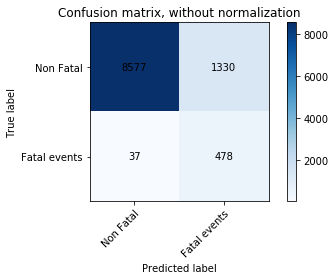

In [15]:
class_names=["Non Fatal","Fatal events"]
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,cmap=plt.cm.Blues):
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,ylabel='True label',xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],ha="center", va="center")
    fig.tight_layout()
    return ax
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, Y_test_pred, classes=class_names)
plt.show()

The confusion matrix shows for the proportion of **non-fatal events identified as fatal is about 13% but the fatal events classified as non-fatal is about 7% which is good**. So, our model does fairly well in predicting if the event was fatal or not.

## Event-type wise prediction
Let,s look at the events and accuracy score for them as we would want to know for which event are we able to predict better and for which we cannot

In [16]:
# Accuracy of Eventype-wise prediction
Events=pd.read_csv('Events.csv')
Eventype_Acc=pd.Series(index=Events.Event)
Eventype_Fatal_Acc=pd.Series(index=Events.Event)
for i in range(len(Events)):
    Event_imask=X_test.Event_label==i
    Y_test_imask=Y_test[Event_imask]
    Y_pred_imask=Y_test_pred[Event_imask]
    Eventype_Acc[Events.Event[i]]=accuracy_score(Y_test_imask,Y_pred_imask)
    Eventype_Fatal_Acc[Events.Event[i]]=accuracy_score(Y_test_imask[Y_test_imask>0],Y_pred_imask[Y_test_imask>0])
Eventype_Acc.fillna(0,inplace=True)
Eventype_Fatal_Acc.fillna(0,inplace=True)

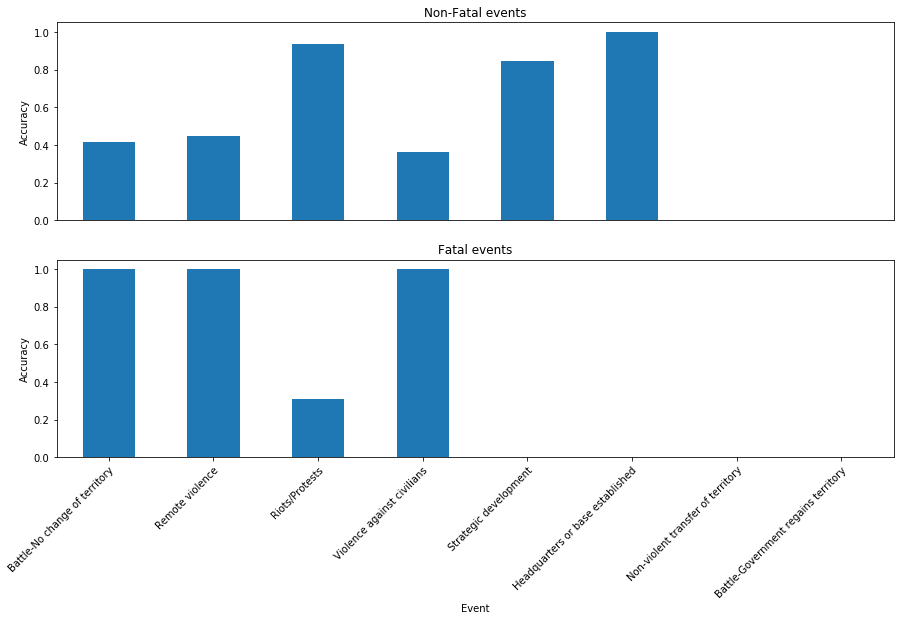

In [17]:
fig, axs=plt.subplots(nrows=2, figsize=(15,8))
for i in range(2):
    if i==0:
        Eventype_Acc.plot.bar(ax=axs[i])
        axs[i].get_xaxis().set_ticks([])
        axs[i].set_title('Non-Fatal events') 
        axs[i].set_ylabel('Accuracy')
        axs[i].set_xlabel(None)
    elif i==1:
        Eventype_Fatal_Acc.plot.bar(ax=axs[i])
        axs[i].set_title('Fatal events') 
        axs[i].set_ylabel('Accuracy')
        axs[i].set_xticklabels(list(Events.Event))
        plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

**It is clear that The Riots/protest events are not being predicted accurately if they turn out to be fatal but for other events the prediction accuracy is failrly good.**

## State wise prediction
Let,s look at the states and accuracy score for them as we would want to know for which state are we able to predict better and for which we cannot

In [18]:
# Accuracy of Eventype-wise prediction
States=pd.read_csv('States.csv')
State_Acc=pd.Series(index=States.state)
State_Fatal_Acc=pd.Series(index=States.state)
for i in range(len(States)):
    State_imask=X_test.State_label==i
    Y_test_imask=Y_test[State_imask]
    Y_pred_imask=Y_test_pred[State_imask]
    State_Acc[States.state[i]]=accuracy_score(Y_test_imask,Y_pred_imask)
    State_Fatal_Acc[States.state[i]]=accuracy_score(Y_test_imask[Y_test_imask>0],Y_pred_imask[Y_test_imask>0])
State_Acc.fillna(0,inplace=True)
State_Fatal_Acc.fillna(0,inplace=True)

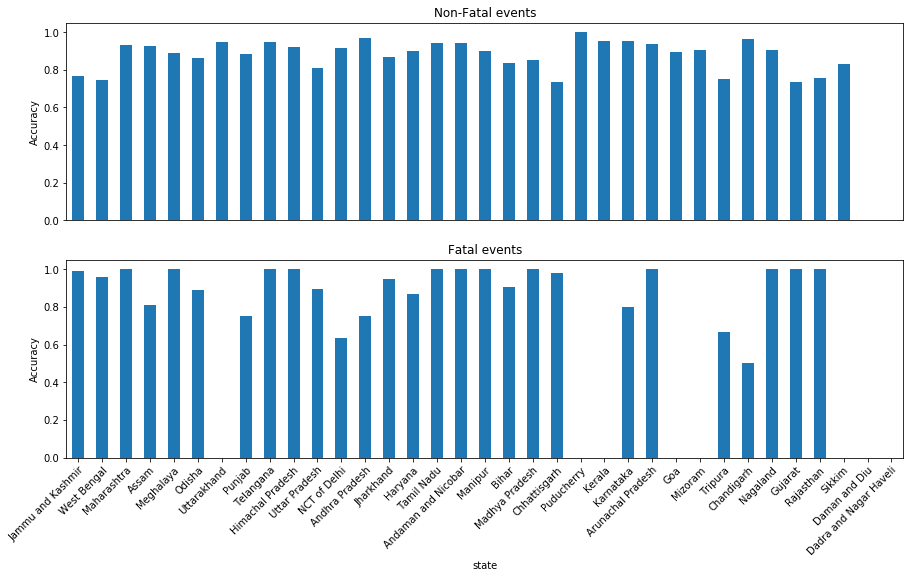

In [19]:
fig, axs=plt.subplots(nrows=2, figsize=(15,8))
for i in range(2):
    if i==0:
        State_Acc.plot.bar(ax=axs[i])
        axs[i].get_xaxis().set_ticks([])
        axs[i].set_title('Non-Fatal events') 
        axs[i].set_ylabel('Accuracy')
        axs[i].set_xlabel(None)
    elif i==1:
        State_Fatal_Acc.plot.bar(ax=axs[i])
        axs[i].set_title('Fatal events') 
        axs[i].set_ylabel('Accuracy')
        axs[i].set_xticklabels(list(States.state))
        plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

Here we are able to identify the states for which fatal event prediction accuracy is low.